In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# You can now see your drive and check the files.
# Replace the path with the actual path to your dataset in your Google Drive
!ls '/content/drive/MyDrive/speech_commands_v0.02.tar.gz'


Mounted at /content/drive
/content/drive/MyDrive/speech_commands_v0.02.tar.gz


In [ ]:
# Step 2: Install required libraries
!pip install librosa
!pip install fastdtw
!pip install tensorflow

import os
import numpy as np
import librosa
import tensorflow as tf
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512547 sha256=48cff0bfd370f4b1be877e8032be38d7f13d0f7323d75c07eca31f71d76af893
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
# Define a function to extract MFCC features from an audio file
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)  # Load the audio file
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Extract MFCC features
    return mfcc

# Directory where the dataset has been extracted
data_dir = '/content/speech_commands_v0.02/'

In [ ]:
import tarfile
# Step 3: Path to the .tar.gz file (adjust the path to your dataset)
tar_gz_path = '/content/drive/MyDrive/speech_commands_v0.02.tar.gz'

# Step 4: Extract the .tar.gz file
extracted_dir = '/content/speech_commands_extracted'
with tarfile.open(tar_gz_path, 'r:gz') as tar_ref:
    tar_ref.extractall(extracted_dir)

# Full list of classes from the Google Speech Commands dataset
classes = [
    'yes', 'no', 'up', 'down', 'left', 'right',
    'on', 'off', 'stop', 'go', 'zero', 'one',
    'two', 'three', 'four', 'five', 'six', 'seven',
    'eight', 'nine', 'backward', 'bed', 'bird',
    'cat', 'dog', 'follow', 'forward', 'happy',
    'house', 'learn', 'marvin', 'sheila', 'tree',
    'visual', 'wow'
]

# Step 5: Preprocessing - Extract MFCC features from audio files
def extract_features(file_path, max_pad_len=40):
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Step 6: Load dataset and extract features, skipping non-directory files
def load_dataset(data_dir, max_samples_per_class=1000):
    X, y = [], []
    labels = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]  # Only directories

    for label in labels:
        files = os.listdir(os.path.join(data_dir, label))
        for file in files[:max_samples_per_class]:
            file_path = os.path.join(data_dir, label, file)
            if os.path.isfile(file_path):  # Ensure it's a file, not a directory
                mfcc = extract_features(file_path)
                if mfcc is not None:
                    X.append(mfcc)
                    y.append(label)

    return np.array(X), np.array(y)


#print("MFCC data shape:", X.shape)
#print("Labels shape:", y.shape)


In [ ]:
def load_dataset(data_dir, max_samples_per_class=1000):
    X, y = [], []  # Initialize lists to hold data and labels
    labels = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]  # Only directories

    for label in labels:
        files = os.listdir(os.path.join(data_dir, label))
        for file in files[:max_samples_per_class]:  # Limit to max samples per class
            file_path = os.path.join(data_dir, label, file)
            if os.path.isfile(file_path):  # Ensure it's a file
                mfcc = extract_features(file_path)
                if mfcc is not None:
                    X.append(mfcc)
                    y.append(label)

    # Convert lists to NumPy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y


In [ ]:
# Load the dataset
X, y = load_dataset(extracted_dir)

# Print the shapes of X and y to verify loading
print("MFCC data shape:", X.shape)
print("Labels shape:", y.shape)


Error processing /content/speech_commands_extracted/_background_noise_/pink_noise.wav: index can't contain negative values
Error processing /content/speech_commands_extracted/_background_noise_/running_tap.wav: index can't contain negative values
Error processing /content/speech_commands_extracted/_background_noise_/white_noise.wav: index can't contain negative values
Error processing /content/speech_commands_extracted/_background_noise_/dude_miaowing.wav: index can't contain negative values


<ipython-input-5-5b39cf095f47>:24: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /content/speech_commands_extracted/_background_noise_/README.md: 
Error processing /content/speech_commands_extracted/_background_noise_/exercise_bike.wav: index can't contain negative values
Error processing /content/speech_commands_extracted/_background_noise_/doing_the_dishes.wav: index can't contain negative values
MFCC data shape: (35000, 13, 40)
Labels shape: (35000,)


In [ ]:
from sklearn.model_selection import train_test_split

# Convert labels to numerical values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (28000, 13, 40) (28000,)
Testing set shape: (7000, 13, 40) (7000,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # MFCC dimensions + channel
num_classes = len(np.unique(y_encoded))

# Create and summarize the model
cnn_model = create_cnn_model(input_shape, num_classes)
cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 13, 40, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 6, 20, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 20, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 10, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 10, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,235 (700.14 KB)

 Trainable params: 179,235 (700.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.1978 - loss: 3.6857 - val_accuracy: 0.6261 - val_loss: 1.2501
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.6901 - loss: 1.0252 - val_accuracy: 0.7653 - val_loss: 0.7957
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.7906 - loss: 0.6856 - val_accuracy: 0.7864 - val_loss: 0.7097
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.8358 - loss: 0.5343 - val_accuracy: 0.8104 - val_loss: 0.6537
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8586 - loss: 0.4598 - val_accuracy: 0.8137 - val_loss: 0.6424
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8755 - loss: 0.3929 - val_accuracy: 0.8274 - val_loss: 0.6108
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.8876 - loss: 0.3520 - val_accuracy: 0.8107 - val_loss: 0.6925
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.8988 - loss: 0.3199 - 

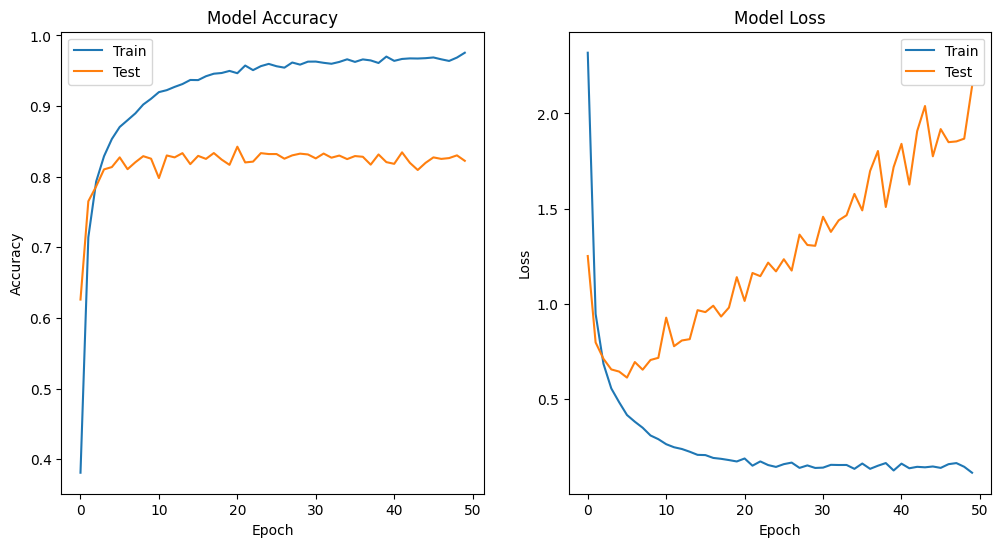

In [ ]:
# Reshape the data to add channel dimension
X_train_reshaped = X_train[..., np.newaxis]
X_test_reshaped = X_test[..., np.newaxis]

# Train the CNN model
history = cnn_model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test)
)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])

plt.show()


In [ ]:
# Extract features using the trained CNN model
def extract_cnn_features(model, data):
    features = model.predict(data)
    return features

# Extract features from training and testing sets
train_features = extract_cnn_features(cnn_model, X_train_reshaped)
test_features = extract_cnn_features(cnn_model, X_test_reshaped)


875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


In [ ]:
# Flatten the features
def flatten_features(features):
    return features.reshape(features.shape[0], -1)  # Flatten each feature map

# Flatten features from training and testing sets
train_features_flattened = flatten_features(train_features)
test_features_flattened = flatten_features(test_features)


In [ ]:
# Function to flatten CNN features
def flatten_features(features):
    # Flatten each feature map to 1-D vector
    return features.reshape(features.shape[0], -1)  # Flatten each sample to a 1-D vector

# Flatten features from training and testing sets
train_features_flattened = flatten_features(train_features)
test_features_flattened = flatten_features(test_features)


In [ ]:
print("Shape of flattened train features:", train_features_flattened.shape)
print("Shape of flattened test features:", test_features_flattened.shape)


Shape of flattened train features: (28000, 35)
Shape of flattened test features: (7000, 35)


In [ ]:
print("Example flattened train feature shape:", train_features_flattened[0].shape)
print("Example flattened test feature shape:", test_features_flattened[0].shape)


Example flattened train feature shape: (35,)
Example flattened test feature shape: (35,)


In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Function to compute DTW distance between two 1-D feature vectors
def compute_dtw_distance(feature_seq1, feature_seq2):
    # Convert 1-D vectors to 2-D arrays with one column
    feature_seq1_2d = feature_seq1.reshape(-1, 1)
    feature_seq2_2d = feature_seq2.reshape(-1, 1)
    distance, _ = fastdtw(feature_seq1_2d, feature_seq2_2d, dist=euclidean)
    return distance

# Function to find the closest match using DTW
def find_closest_match(test_feature, train_features, train_labels):
    distances = [compute_dtw_distance(test_feature, train_feature) for train_feature in train_features]
    closest_index = np.argmin(distances)
    return train_labels[closest_index]

# Example usage: Compare the first test sample to the training samples
test_sample_index = 0
actual_label = label_encoder.inverse_transform([y_test[test_sample_index]])
predicted_label = find_closest_match(test_features_flattened[test_sample_index], train_features_flattened, y_train)
print(f"Predicted label for test sample {test_sample_index}: {predicted_label}")
print(f"Actual label for test sample {test_sample_index}: {actual_label[0]}")

Predicted label for test sample 0: 8
Actual label for test sample 0: wow


In [ ]:
# Test the first 10 samples
for test_sample_index in range(10):
    # Get the actual label for the current test sample
    actual_label = label_encoder.inverse_transform([y_test[test_sample_index]])

    # Predict the label using the find_closest_match function
    predicted_label = find_closest_match(test_features_flattened[test_sample_index], train_features_flattened, y_train)

    # Print the results
    print(f"Sample index {test_sample_index}:")
    print(f"  Predicted label: {predicted_label}")
    print(f"  Actual label: {actual_label[0]}")
    print()


Sample index 0:
  Predicted label: 8
  Actual label: wow

Sample index 1:
  Predicted label: 24
  Actual label: zero

Sample index 2:
  Predicted label: 5
  Actual label: up

Sample index 3:
  Predicted label: 15
  Actual label: dog

Sample index 4:
  Predicted label: 5
  Actual label: left

Sample index 5:
  Predicted label: 31
  Actual label: six

Sample index 6:
  Predicted label: 10
  Actual label: one

Sample index 7:
  Predicted label: 13
  Actual label: seven

Sample index 8:
  Predicted label: 5
  Actual label: nine

Sample index 9:
  Predicted label: 13
  Actual label: down



In [ ]:
# Example mapping if you have a list of class names
class_names = classes  # This should be the same list you used for y_train and y_test

# Print the actual class name for label 12
print("Predicted label class name:", class_names[29])


Predicted label class name: learn


In [ ]:
# Your code here that extracts features using CNN and defines DTW logic

# Function to calculate accuracy
def calculate_accuracy(test_features, test_labels, train_features, train_labels):
    correct_predictions = 0
    total_samples = len(test_features)

    for i in range(total_samples):
        predicted_label = find_closest_match(test_features[i], train_features, train_labels)
        if predicted_label == test_labels[i]:
            correct_predictions += 1

    accuracy = correct_predictions / total_samples
    return accuracy

# Example usage: Calculate accuracy
accuracy = calculate_accuracy(test_features_flattened, y_test, train_features_flattened, y_train)
print(f"Model accuracy after DTW: {accuracy * 100:.2f}%")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Example code for predictions and evaluation
def evaluate_model(test_features, train_features, train_labels, true_labels):
    predicted_labels = [find_closest_match(test_feature, train_features, train_labels) for test_feature in test_features]
    print(confusion_matrix(true_labels, predicted_labels))
    print(classification_report(true_labels, predicted_labels))

# Assuming y_test is your true labels for the test set
evaluate_model(test_features_flattened, train_features_flattened, y_train, y_test)


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Define subset size
test_subset_size = 100

# Select a subset of the test set
test_features_subset = test_features_flattened[:test_subset_size]
true_labels_subset = y_test[:test_subset_size]

# Compute predictions for the subset
def evaluate_model_subset(test_features, train_features, train_labels, true_labels):
    predicted_labels = [find_closest_match(test_feature, train_features, train_labels) for test_feature in test_features]
    cm = confusion_matrix(true_labels, predicted_labels)
    cr = classification_report(true_labels, predicted_labels, target_names=labels)
    return cm, cr

# Evaluate the model on the subset
conf_matrix, class_report = evaluate_model_subset(test_features_subset, train_features_flattened, y_train, true_labels_subset)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


KeyboardInterrupt: 